In [3]:
import math
import os
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data

from torchvision import datasets
from torchvision import transforms
from torchvision import utils
from pathlib import Path
from sklearn.metrics import accuracy_score 
import torchvision.models as models 

random.seed(123)
torch.manual_seed(123)

data_directory='E:/DL/mini_imagenet_validation/val'
path_to_replace='E:/DL/mini_imagenet_validation/val'
new_path='E:/calibration_datasets/tiny_imagenet/train'

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
is_gpu = 1 if device == "cude:0" else 0

In [47]:
def create_calibration_dataset(path, 
                               n_images=2, 
                               path_to_replace='/kaggle_tiny_imagenet/tiny-imagenet-200/dataset_tiny_imagenet/train',
                               new_path='/calibration_datasets/tiny_imagenet/train'):
   for root, dirs, files in os.walk(path):
        i=0
        for name in files:
            if i<n_images and name.endswith(".JPEG"):
                image_path=os.path.join(root, name)
                image=cv2.imread(image_path)
                image_name=image_path.split('\\')[-1]
                image_path=image_path.replace(path_to_replace, new_path)
                path_without_image_name=image_path.replace(image_name, '')
                Path(path_without_image_name).mkdir(parents=True, exist_ok=True)
                image_path=image_path.replace(image_name, 'calib_'+image_name)
                cv2.imwrite(image_path, image)
                i+=1

In [ ]:
create_calibration_dataset(data_directory, n_images=2, path_to_replace=path_to_replace, new_path=new_path)

In [34]:
def load_dataset(directory, batch_size, subset_size=2, if_subset=True):

    image_folder = datasets.ImageFolder(
        root=directory,
        transform= transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]))

 
    subset_indices = []

    if if_subset:
        for class_index in range(len(image_folder.classes)):
            class_indices = np.where(np.array(image_folder.targets) == class_index)[0]
            
            if len(class_indices) >= subset_size:
                selected_indices = np.random.choice(class_indices, size=subset_size, replace=False)
                subset_indices.extend(selected_indices)

        image_folder = data.Subset(image_folder, subset_indices)
    dataloader = data.DataLoader(
        image_folder, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=2
    )

    return dataloader

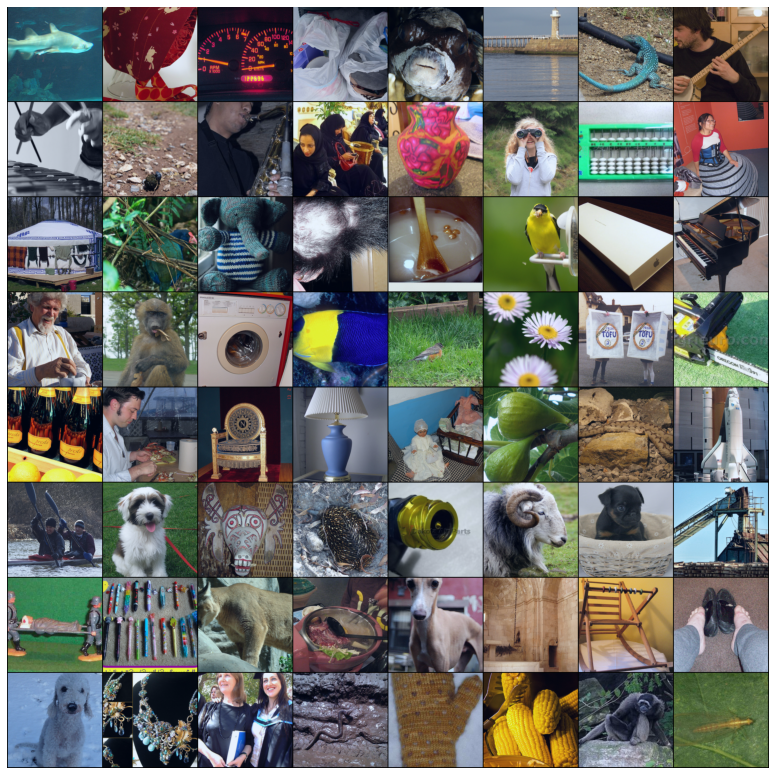

In [42]:
dataloader = load_dataset(data_directory, batch_size=128, subset_size=2, if_subset=True)

real_batch = next(iter(dataloader))

plt.figure(figsize=(14,14))
plt.axis("off")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [44]:
resnet18 = models.resnet18(pretrained=True)

In [45]:
def predict_from_dataloader(dataloader, model, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            if i == 0:
                all_predicted = predicted
                all_labels = labels
            else:
                all_predicted = torch.cat((all_predicted, predicted), 0)
                all_labels = torch.cat((all_labels, labels), 0)
    return all_predicted, all_labels

In [46]:
all_predicted, all_labels = predict_from_dataloader(dataloader, resnet18, device)
accuracy_score(all_labels.cpu().numpy(), all_predicted.cpu().numpy())

0.7004028197381672